In [1]:
from torchvision import datasets
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from vit_pytorch import ViT  # ViT model
import os
from torchmetrics import Accuracy
from pathlib import Path
from captum.attr import IntegratedGradients, GradientShap, DeepLift
from utils import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataloader

In [3]:
BATCH_SIZE = 32
mnist_transforms = transforms.Compose([transforms.ToTensor()])
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True, transform=mnist_transforms)
train_val_dataset, test_dataset
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
len(train_dataloader), len(val_dataloader), len(test_dataloader) 

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.46MB/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 251kB/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.48MB/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 14.9MB/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



(1688, 188, 313)

### First ViT Model

In [12]:
# Experiment tracking setup
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "VisionTransformer_v1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_vit = ViT(
    image_size=28,       # MNIST images are 28x28
    patch_size=4,        # 4 patches per dimension (28/7)
    num_classes=10,      # 10 output classes for digits 0-9
    dim=64,             # Embedding dimension
    depth=6,             # Number of transformer layers
    heads=8,             # Number of attention heads
    mlp_dim=128,         # Hidden dimension in MLP layers
    dropout=0.1,         # Dropout rate in transformer
    emb_dropout=0.1,     # Dropout rate for embeddings
    channels = 1
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=1e-4)



accuracy = Accuracy(task='multiclass', num_classes=10).to(device)
# Training and Validation Loops
EPOCHS = 15
for epoch in tqdm(range(EPOCHS)):
    # Training Loop
    train_loss, train_acc = 0.0, 0.0
    model_vit.train()
    torch.manual_seed(epoch)
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
       # print(X.shape)
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model_vit(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy(y_pred, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Average metrics
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Validation Loop
    val_loss, val_acc = 0.0, 0.0
    model_vit.eval()
    torch.manual_seed(epoch)
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_pred = model_vit(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_acc += accuracy(y_pred, y)

    # Average metrics
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # Log metrics to TensorBoard
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)

    # Print progress
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Accuracy: {val_acc:.5f}")

  7%|▋         | 1/15 [00:24<05:36, 24.06s/it]

Epoch: 1 | Train Loss: 0.67245 | Train Accuracy: 0.79541 | Val Loss: 0.18838 | Val Accuracy: 0.94614


 13%|█▎        | 2/15 [00:47<05:09, 23.81s/it]

Epoch: 2 | Train Loss: 0.20723 | Train Accuracy: 0.93926 | Val Loss: 0.12411 | Val Accuracy: 0.96326


 20%|██        | 3/15 [01:10<04:37, 23.13s/it]

Epoch: 3 | Train Loss: 0.15586 | Train Accuracy: 0.95292 | Val Loss: 0.10359 | Val Accuracy: 0.96908


 27%|██▋       | 4/15 [01:32<04:10, 22.80s/it]

Epoch: 4 | Train Loss: 0.12426 | Train Accuracy: 0.96233 | Val Loss: 0.08871 | Val Accuracy: 0.97307


 33%|███▎      | 5/15 [01:54<03:47, 22.73s/it]

Epoch: 5 | Train Loss: 0.10835 | Train Accuracy: 0.96645 | Val Loss: 0.07891 | Val Accuracy: 0.97606


 40%|████      | 6/15 [02:18<03:27, 23.00s/it]

Epoch: 6 | Train Loss: 0.09641 | Train Accuracy: 0.96990 | Val Loss: 0.07987 | Val Accuracy: 0.97523


 47%|████▋     | 7/15 [02:37<02:54, 21.80s/it]

Epoch: 7 | Train Loss: 0.08529 | Train Accuracy: 0.97340 | Val Loss: 0.07453 | Val Accuracy: 0.97689


 53%|█████▎    | 8/15 [02:57<02:27, 21.06s/it]

Epoch: 8 | Train Loss: 0.07556 | Train Accuracy: 0.97645 | Val Loss: 0.06897 | Val Accuracy: 0.97939


 60%|██████    | 9/15 [03:19<02:09, 21.56s/it]

Epoch: 9 | Train Loss: 0.07052 | Train Accuracy: 0.97795 | Val Loss: 0.06834 | Val Accuracy: 0.97939


 67%|██████▋   | 10/15 [03:39<01:44, 20.96s/it]

Epoch: 10 | Train Loss: 0.06371 | Train Accuracy: 0.98002 | Val Loss: 0.06547 | Val Accuracy: 0.98072


 73%|███████▎  | 11/15 [03:59<01:23, 20.79s/it]

Epoch: 11 | Train Loss: 0.05945 | Train Accuracy: 0.98104 | Val Loss: 0.06326 | Val Accuracy: 0.98155


 80%|████████  | 12/15 [04:22<01:04, 21.42s/it]

Epoch: 12 | Train Loss: 0.05435 | Train Accuracy: 0.98258 | Val Loss: 0.06141 | Val Accuracy: 0.98105


 87%|████████▋ | 13/15 [04:45<00:43, 21.80s/it]

Epoch: 13 | Train Loss: 0.04922 | Train Accuracy: 0.98449 | Val Loss: 0.06474 | Val Accuracy: 0.98172


 93%|█████████▎| 14/15 [05:07<00:21, 21.77s/it]

Epoch: 14 | Train Loss: 0.04630 | Train Accuracy: 0.98515 | Val Loss: 0.06162 | Val Accuracy: 0.98305


100%|██████████| 15/15 [05:30<00:00, 22.00s/it]

Epoch: 15 | Train Loss: 0.04370 | Train Accuracy: 0.98554 | Val Loss: 0.06028 | Val Accuracy: 0.98105


In [4]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ViT_v1_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#Saving the model
#print(f"Saving the model: {MODEL_SAVE_PATH}")
#torch.save(obj=model_vit.state_dict(), f=MODEL_SAVE_PATH)

In [5]:
#Loading the saved model
model_ViT_mnist_loaded = ViT(
    image_size=28,       # MNIST images are 28x28
    patch_size=4,        # 4 patches per dimension (28/7)
    num_classes=10,      # 10 output classes for digits 0-9
    dim=64,             # Embedding dimension
    depth=6,             # Number of transformer layers
    heads=8,             # Number of attention heads
    mlp_dim=128,         # Hidden dimension in MLP layers
    dropout=0.1,         # Dropout rate in transformer
    emb_dropout=0.1,     # Dropout rate for embeddings
    channels = 1
).to(device)

model_ViT_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))


/tmp/ipykernel_12588/609405720.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ViT_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

### Feature Attributions for first ViT model

In [6]:
model_loaded = model_ViT_mnist_loaded.to(device)

ig = IntegratedGradients(model_loaded)
gs = GradientShap(model_loaded)
dl = DeepLift(model_loaded)

all_attributions_ig = []
all_labels = []
all_attributions_gs = []
all_attributions_ks = []
all_attributions_dl = []
all_batches= []
model_loaded.eval()
torch.manual_seed(210)
for batch_samples, batch_labels in tqdm(test_dataloader):
    # Ensure samples have the correct shape
    batch_labels = batch_labels.to(device)
    batch_samples = batch_samples.requires_grad_().to(device) # Enable gradients for attribution
    baseline_dist = torch.zeros((batch_samples.shape[0],1,28,28)).to(device)
    

    # Calculate the attributions for each sample in the batch
    attributions, deltas = ig.attribute(batch_samples, target=batch_labels, return_convergence_delta=True)

    
    # Append attributions and labels for further analysis

    all_attributions_ig.append(attributions)
    all_labels.append(batch_labels)
    all_batches.append(batch_samples.detach())
    attributions_gs, deltas = gs.attribute(batch_samples, target=batch_labels,  baselines=baseline_dist,return_convergence_delta=True)
    all_attributions_gs.append(attributions_gs)
    

    attributions_dl = dl.attribute(batch_samples, target=batch_labels)
    all_attributions_dl.append(attributions_dl)


# Concatenate all attributions and labels
all_attributions_ig = torch.cat(all_attributions_ig, dim=0)  
all_labels = torch.cat(all_labels, dim=0)

all_attributions_gs = torch.cat(all_attributions_gs, dim=0)
all_attributions_dl = torch.cat(all_attributions_dl, dim=0)

all_batches = torch.cat(all_batches,dim=0)

  0%|          | 0/313 [00:00<?, ?it/s]/home/sven/miniconda3/envs/torch/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
100%|██████████| 313/313 [02:10<00:00,  2.40it/s]


In [7]:
def filter_explanations(C1,C2,all_attributions_ig,all_attributions_dl,all_attributions_gs,all_labels):
    data={'X':[],'Y':[],'Features':[],'IG':[],'GS':[],'DL':[]}
    for c1,c2 in zip(C1,C2):
        data['IG'].append(torch.abs(all_attributions_ig[all_labels ==c1 ].mean(axis=0)-all_attributions_ig[all_labels ==c2 ].mean(axis=0)).cpu().detach().numpy())
        data['DL'].append(torch.abs(all_attributions_dl[all_labels ==c1 ].mean(axis=0)-all_attributions_dl[all_labels ==c2 ].mean(axis=0)).cpu().detach().numpy())
        data['GS'].append(torch.abs(all_attributions_gs[all_labels ==c1 ].mean(axis=0)-all_attributions_gs[all_labels ==c2 ].mean(axis=0)).cpu().detach().numpy())

        data_X = all_batches[all_labels==c1].mean(axis=0)[0,:,:]
        data_Y = all_batches[all_labels==c2].mean(axis=0)[0,:,:]

        data['X'].append(data_X)
        data['Y'].append(data_Y)

        rf, _, _ = remove_important_features(data_X.cpu().detach().numpy().reshape(1,784),data_Y.cpu().detach().numpy().reshape(1,784),250,1000)

        Features = np.zeros(784)
        f_id = []
        contributions = []
        k=1
        for d in rf:
            i = d["removed_feature"]
            Features[i] = 1/(np.log(k+1)**3)
            k+=0.075
            f_id.append(i)
            contributions.append(d['contribution_value'])
        data['Features'].append(Features)

    return data


def plot_MNIST_explanations(n_rows,n_cols,data):
    fig, ax = plt.subplots(n_rows,n_cols,figsize=(12,6))
    
    for i in range(n_rows):
        data_X = data['X'][i]
        data_Y = data['Y'][i]
        Features = data['Features'][i]
        ig_plot = data['IG'][i]
        gs_plot = data['GS'][i]
        dl_plot = data['DL'][i]
        ###first row set titles
        if i==0:
            ax[i,0].set_title('Before Drift',fontsize=17)
            ax[i,1].set_title('After Drift',fontsize=17)
            ax[i,2].set_title('SWD',fontsize=17)
            ax[i,3].set_title('IG',fontsize=17)
            ax[i,4].set_title('Grad SHAP',fontsize=17)
            ax[i,5].set_title('DeepLift',fontsize=17)

        ax[i,0].imshow(data_X.cpu().numpy(),cmap='gray')
        ax[i,0].set_xticks([])
        ax[i,0].set_yticks([])
        ax[i,1].imshow(data_Y.cpu().numpy(),cmap='gray')
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,2].imshow(np.float64(Features.reshape(28,28)),cmap='plasma')
        ax[i,2].set_xticks([])
        ax[i,2].set_yticks([])
        ax[i,3].imshow(ig_plot[0,:,:],cmap='plasma')
        ax[i,3].set_xticks([])
        ax[i,3].set_yticks([])
        ax[i,4].imshow(gs_plot[0,:,:], cmap='plasma')
        ax[i,4].set_xticks([])
        ax[i,4].set_yticks([])
        ax[i,5].imshow(dl_plot[0,:,:], cmap='plasma')
        ax[i,5].set_xticks([])
        ax[i,5].set_yticks([])
    

    fig.tight_layout()

    return fig

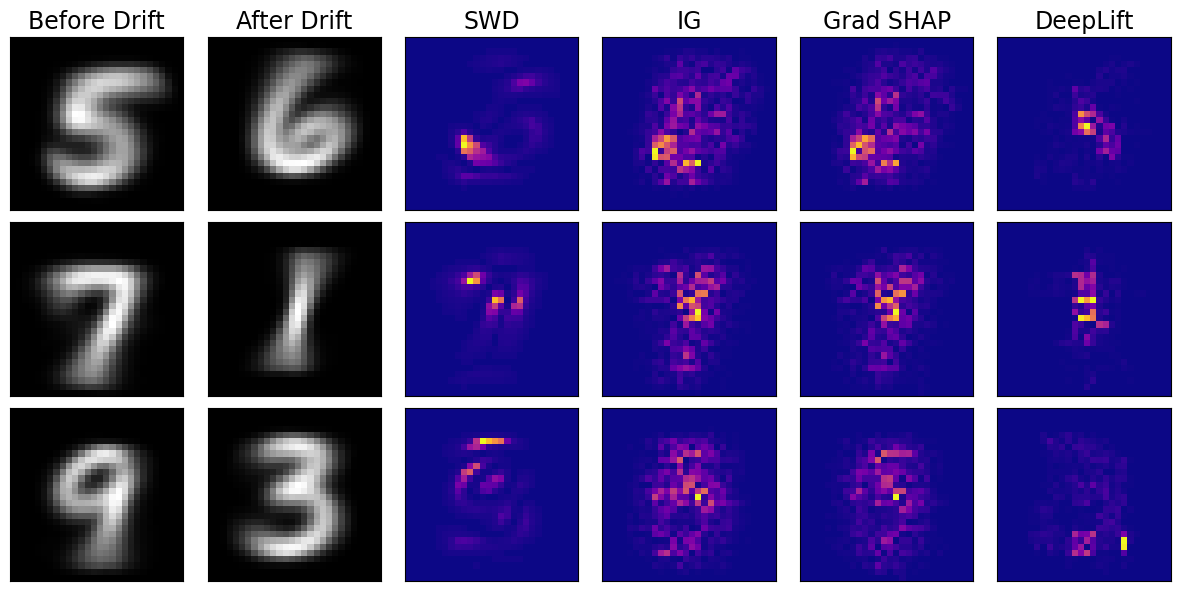

In [8]:
data = filter_explanations([5,7,9],[6,1,3],all_attributions_ig,all_attributions_dl,all_attributions_gs,all_labels)
fig = plot_MNIST_explanations(3,6,data)

### Second ViT model

In [18]:
# Experiment tracking setup
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "VisionTransformer_v2"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_vit = ViT(
    image_size=28,       # MNIST images are 28x28
    patch_size=7,        # 4 patches per dimension (28/7)
    num_classes=10,      # 10 output classes for digits 0-9
    dim=64,             # Embedding dimension
    depth=6,             # Number of transformer layers
    heads=8,             # Number of attention heads
    mlp_dim=128,         # Hidden dimension in MLP layers
    dropout=0.1,         # Dropout rate in transformer
    emb_dropout=0.1,     # Dropout rate for embeddings
    channels = 1
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=1e-4)



accuracy = Accuracy(task='multiclass', num_classes=10).to(device)
# Training and Validation Loops
EPOCHS = 15
for epoch in tqdm(range(EPOCHS)):
    # Training Loop
    train_loss, train_acc = 0.0, 0.0
    model_vit.train()
    torch.manual_seed(epoch)
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
       # print(X.shape)
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model_vit(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy(y_pred, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Average metrics
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Validation Loop
    val_loss, val_acc = 0.0, 0.0
    model_vit.eval()
    torch.manual_seed(epoch)
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_pred = model_vit(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_acc += accuracy(y_pred, y)

    # Average metrics
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # Log metrics to TensorBoard
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)

    # Print progress
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Accuracy: {val_acc:.5f}")


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ViT_v2_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_vit.state_dict(), f=MODEL_SAVE_PATH)  

  7%|▋         | 1/15 [00:19<04:27, 19.11s/it]

Epoch: 1 | Train Loss: 0.58614 | Train Accuracy: 0.82868 | Val Loss: 0.18049 | Val Accuracy: 0.95213


 13%|█▎        | 2/15 [00:37<04:04, 18.80s/it]

Epoch: 2 | Train Loss: 0.19785 | Train Accuracy: 0.94339 | Val Loss: 0.12639 | Val Accuracy: 0.96393


 20%|██        | 3/15 [00:55<03:42, 18.53s/it]

Epoch: 3 | Train Loss: 0.14493 | Train Accuracy: 0.95640 | Val Loss: 0.09967 | Val Accuracy: 0.96809


 27%|██▋       | 4/15 [01:14<03:23, 18.53s/it]

Epoch: 4 | Train Loss: 0.11949 | Train Accuracy: 0.96323 | Val Loss: 0.08961 | Val Accuracy: 0.97291


 33%|███▎      | 5/15 [01:34<03:10, 19.04s/it]

Epoch: 5 | Train Loss: 0.09859 | Train Accuracy: 0.96997 | Val Loss: 0.08896 | Val Accuracy: 0.97357


 40%|████      | 6/15 [01:57<03:03, 20.42s/it]

Epoch: 6 | Train Loss: 0.08807 | Train Accuracy: 0.97221 | Val Loss: 0.07903 | Val Accuracy: 0.97540


 47%|████▋     | 7/15 [02:15<02:37, 19.74s/it]

Epoch: 7 | Train Loss: 0.07868 | Train Accuracy: 0.97571 | Val Loss: 0.07771 | Val Accuracy: 0.97806


 53%|█████▎    | 8/15 [02:35<02:16, 19.57s/it]

Epoch: 8 | Train Loss: 0.06964 | Train Accuracy: 0.97754 | Val Loss: 0.07062 | Val Accuracy: 0.97856


 60%|██████    | 9/15 [02:57<02:02, 20.36s/it]

Epoch: 9 | Train Loss: 0.06114 | Train Accuracy: 0.98002 | Val Loss: 0.06425 | Val Accuracy: 0.98138


 67%|██████▋   | 10/15 [03:18<01:43, 20.74s/it]

Epoch: 10 | Train Loss: 0.05730 | Train Accuracy: 0.98147 | Val Loss: 0.06863 | Val Accuracy: 0.97955


 73%|███████▎  | 11/15 [03:38<01:22, 20.58s/it]

Epoch: 11 | Train Loss: 0.05020 | Train Accuracy: 0.98391 | Val Loss: 0.06688 | Val Accuracy: 0.98039


 80%|████████  | 12/15 [03:59<01:02, 20.70s/it]

Epoch: 12 | Train Loss: 0.04727 | Train Accuracy: 0.98480 | Val Loss: 0.06569 | Val Accuracy: 0.98072


 87%|████████▋ | 13/15 [04:19<00:40, 20.47s/it]

Epoch: 13 | Train Loss: 0.04367 | Train Accuracy: 0.98569 | Val Loss: 0.06458 | Val Accuracy: 0.98388


 93%|█████████▎| 14/15 [04:40<00:20, 20.67s/it]

Epoch: 14 | Train Loss: 0.03777 | Train Accuracy: 0.98774 | Val Loss: 0.06079 | Val Accuracy: 0.98338


100%|██████████| 15/15 [05:02<00:00, 20.17s/it]

Epoch: 15 | Train Loss: 0.03673 | Train Accuracy: 0.98793 | Val Loss: 0.06420 | Val Accuracy: 0.98321
Saving the model: models\ViT_v2_mnist.pth


In [9]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ViT_v2_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Loading the saved model
model_ViT_mnist_loaded_v2 = ViT(
    image_size=28,       # MNIST images are 28x28
    patch_size=7,        # 4 patches per dimension (28/7)
    num_classes=10,      # 10 output classes for digits 0-9
    dim=64,             # Embedding dimension
    depth=6,             # Number of transformer layers
    heads=8,             # Number of attention heads
    mlp_dim=128,         # Hidden dimension in MLP layers
    dropout=0.1,         # Dropout rate in transformer
    emb_dropout=0.1,     # Dropout rate for embeddings
    channels = 1
).to(device)
model_ViT_mnist_loaded_v2.load_state_dict(torch.load(MODEL_SAVE_PATH))


/tmp/ipykernel_12588/3303951566.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ViT_mnist_loaded_v2.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [10]:
model_loaded = model_ViT_mnist_loaded_v2.to(device)

ig = IntegratedGradients(model_loaded)
gs = GradientShap(model_loaded)
dl = DeepLift(model_loaded)

all_attributions_ig = []
all_labels = []
all_attributions_gs = []
all_attributions_ks = []
all_attributions_dl = []
all_batches= []
model_loaded.eval()
torch.manual_seed(210)
for batch_samples, batch_labels in tqdm(test_dataloader):
    # Ensure samples have the correct shape
    batch_labels = batch_labels.to(device)
    batch_samples = batch_samples.requires_grad_().to(device) # Enable gradients for attribution
    baseline_dist = torch.zeros((batch_samples.shape[0],1,28,28)).to(device)
    

    # Calculate the attributions for each sample in the batch
    attributions, deltas = ig.attribute(batch_samples, target=batch_labels, return_convergence_delta=True)

    
    # Append attributions and labels for further analysis

    all_attributions_ig.append(attributions)
    all_labels.append(batch_labels)
    all_batches.append(batch_samples.detach())
    attributions_gs, deltas = gs.attribute(batch_samples, target=batch_labels,  baselines=baseline_dist,return_convergence_delta=True)
    all_attributions_gs.append(attributions_gs)
    

    attributions_dl = dl.attribute(batch_samples, target=batch_labels)
    all_attributions_dl.append(attributions_dl)


# Concatenate all attributions and labels
all_attributions_ig = torch.cat(all_attributions_ig, dim=0)  
all_labels = torch.cat(all_labels, dim=0)

all_attributions_gs = torch.cat(all_attributions_gs, dim=0)
all_attributions_dl = torch.cat(all_attributions_dl, dim=0)

all_batches = torch.cat(all_batches,dim=0)

100%|██████████| 313/313 [01:04<00:00,  4.84it/s]


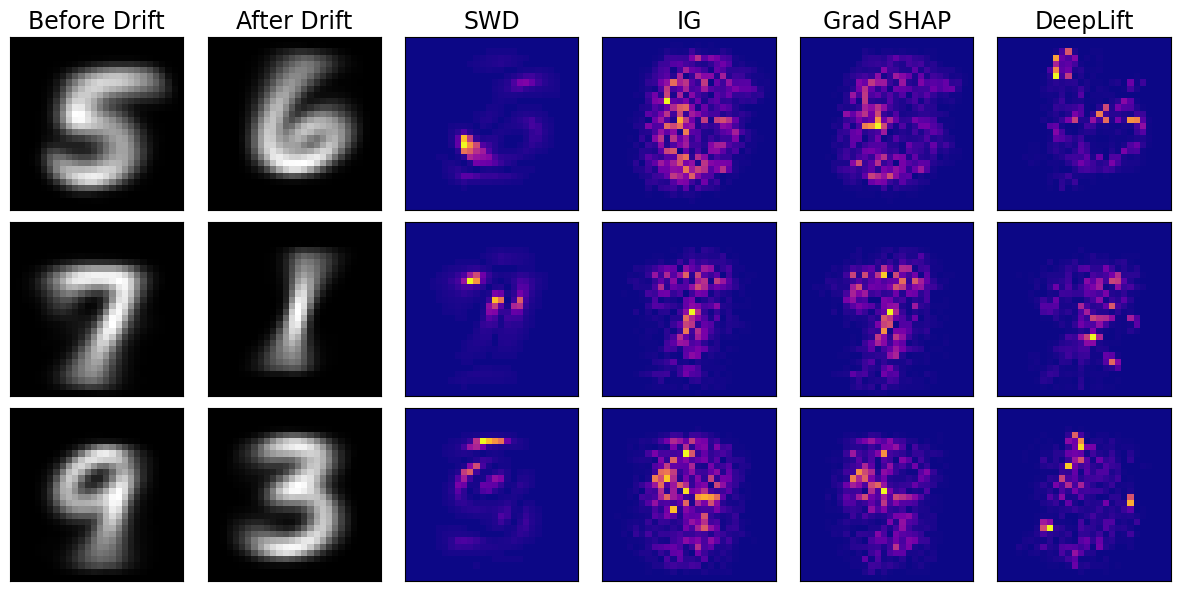

In [11]:
data = filter_explanations([5,7,9],[6,1,3],all_attributions_ig,all_attributions_dl,all_attributions_gs,all_labels)
fig = plot_MNIST_explanations(3,6,data)

### CNN

In [12]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

In [ ]:
# Experiment tracking setup
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "LeNet5"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_lenet5 = LeNet5V1().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lenet5.parameters(), lr=1e-4)



accuracy = Accuracy(task='multiclass', num_classes=10).to(device)
# Training and Validation Loops
EPOCHS = 15
for epoch in tqdm(range(EPOCHS)):
    # Training Loop
    train_loss, train_acc = 0.0, 0.0
    model_lenet5.train()
    torch.manual_seed(epoch)
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
       # print(X.shape)
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model_lenet5(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy(y_pred, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Average metrics
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Validation Loop
    val_loss, val_acc = 0.0, 0.0
    model_lenet5.eval()
    torch.manual_seed(epoch)
    with torch.no_grad():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            y_pred = model_lenet5(X)
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            val_acc += accuracy(y_pred, y)

    # Average metrics
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # Log metrics to TensorBoard
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)

    # Print progress
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Accuracy: {val_acc:.5f}")


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "LENeT5_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_lenet5.state_dict(), f=MODEL_SAVE_PATH)  

Saving the model: models\LENeT5_mnist.pth


In [13]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "LENeT5_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_LeNet5_mnist_loaded = LeNet5V1().to(device)
model_LeNet5_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

/tmp/ipykernel_12588/3378268383.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_LeNet5_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [14]:
model_loaded = model_LeNet5_mnist_loaded.to(device)

ig = IntegratedGradients(model_loaded)
gs = GradientShap(model_loaded)
dl = DeepLift(model_loaded)

all_attributions_ig = []
all_labels = []
all_attributions_gs = []
all_attributions_ks = []
all_attributions_dl = []
all_batches= []
model_loaded.eval()
torch.manual_seed(210)
for batch_samples, batch_labels in tqdm(test_dataloader):
    # Ensure samples have the correct shape
    batch_labels = batch_labels.to(device)
    batch_samples = batch_samples.requires_grad_().to(device) # Enable gradients for attribution
    baseline_dist = torch.zeros((batch_samples.shape[0],1,28,28)).to(device)
    

    # Calculate the attributions for each sample in the batch
    attributions, deltas = ig.attribute(batch_samples, target=batch_labels, return_convergence_delta=True)

    
    # Append attributions and labels for further analysis

    all_attributions_ig.append(attributions)
    all_labels.append(batch_labels)
    all_batches.append(batch_samples.detach())
    attributions_gs, deltas = gs.attribute(batch_samples, target=batch_labels,  baselines=baseline_dist,return_convergence_delta=True)
    all_attributions_gs.append(attributions_gs)
    

    attributions_dl = dl.attribute(batch_samples, target=batch_labels)
    all_attributions_dl.append(attributions_dl)


# Concatenate all attributions and labels
all_attributions_ig = torch.cat(all_attributions_ig, dim=0)  
all_labels = torch.cat(all_labels, dim=0)

all_attributions_gs = torch.cat(all_attributions_gs, dim=0)
all_attributions_dl = torch.cat(all_attributions_dl, dim=0)

all_batches = torch.cat(all_batches,dim=0)

100%|██████████| 313/313 [00:09<00:00, 33.16it/s]


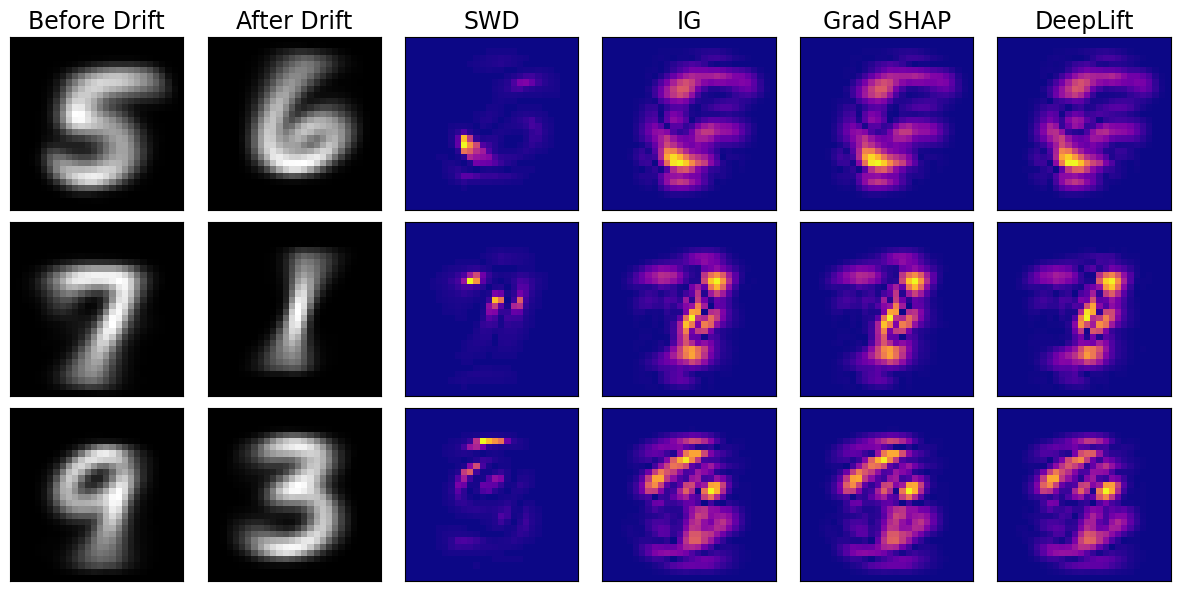

In [15]:
data = filter_explanations([5,7,9],[6,1,3],all_attributions_ig,all_attributions_dl,all_attributions_gs,all_labels)
fig = plot_MNIST_explanations(3,6,data)